# EdgeSHAPer Shapley Values convergence and variance study

In [1]:
import torch
from torchdrug import data
import pandas as pd
import numpy as np
import random

from rdkit import Chem
from rdkit.Chem import Draw
from pysmiles import read_smiles
import networkx as nx

from rdkit_heatmaps import mapvalues2mol
from rdkit_heatmaps.utils import transform2png
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from tqdm.notebook import tqdm
%matplotlib inline

In [2]:
# for debugging
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

## Reproducibility Settings

In [3]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

## Data Loading

In [4]:
DATASET_TYPE = "single" #"single", dual
TARGET = 1
TRAINING_SET_SPLIT = "FULL" #None, FULL, 0, 1, 2
MODEL_NUM = 0 #2 with single targe 1 vs random
SAVE = False
TARGET_CPDS = "P14416_P42336" #"P14416_P42336 (single) #P27338_P22303 P27338_P29274 Q9Y5N1_P31645 (dual)
DATASET_NAME = "chembl29_predicting_target_" + TARGET_CPDS + "_target_"+ str(TARGET) +"_vs_random_cpds" #"chembl29_dt_cpds_" + TARGET_CPDS + "_balanced" #"chembl29_predicting_target_" + TARGET_CPDS + "_target_"+ str(TARGET) +"_vs_random_cpds" # "chembl29_dt_cpds_" + TARGET_CPDS + "_balanced" #"chembl29_predicting_target_P14416_P42336_target_1_vs_random_cpds"
CSV_DATA_PATH = "../data/"+ DATASET_NAME + ".csv"

SELECTED_CPD = "C#Cc1ccc2sc(C(=O)NCCCCN3CCN(c4ccccc4OC)CC3)cc2c1" #["C#Cc1ccc2sc(C(=O)NCCCCN3CCN(c4ccccc4OC)CC3)cc2c1", "Cc1ncsc1-c1nnc(SCCCN2CCC3(CC3c3ccc(C(F)(F)F)cc3)C2)n1C"] #[]

smiles_df = pd.read_csv(CSV_DATA_PATH, sep = ",")
display(smiles_df.head())
display(smiles_df.shape)

,nonstereo_aromatic_smiles,target_pair,label
0,Brc1ccc(CNCCN2CCN(Cc3cc4ccccc4[nH]3)CC2)cc1,P14416_P42336,0
1,Brc1ccc(N2CCN(Cc3ccccc3)CC2)c2cc[nH]c12,P14416_P42336,0
2,Brc1ccc(NCCN2CCN(CCc3c[nH]c4ccccc34)CC2)cc1,P14416_P42336,0
3,Brc1ccc(NCCN2CCN(Cc3cc4ccccc4[nH]3)CC2)cc1,P14416_P42336,0
4,Brc1cccc(N2CCN(Cc3cc4ccccn4n3)CC2)n1,P14416_P42336,0


(8348, 3)

## Define Custom Class
We need to define the ChEMBL datasets class in order to load the model

In [5]:
import os

from torchdrug.core import Registry as R
from torchdrug.utils import doc


@R.register("datasets.ChEMBL") #only first time you launch the class
#@doc.copy_args(data.MoleculeDataset.load_csv, ignore=("path", "smiles_field", "target_fields"))
class ChEMBL(data.MoleculeDataset):
    

    def __init__(self, path, smiles_field, target_fields, verbose=1, **kwargs):
        # path = os.path.expanduser(path)# if not os.path.exists(path):
        #     os.makedirs(path)
        self.path = path
        self.smiles_field = smiles_field
        self.target_fields= target_fields
        #print(self.path)
        # zip_file = utils.download(self.url, path, md5=self.md5)
        # csv_file = utils.extract(zip_file)

        self.load_csv(self.path, smiles_field=self.smiles_field, target_fields=self.target_fields,
                      verbose=verbose, **kwargs)

In [6]:
#target_fields = ["target1", "target2"] if DATASET_TYPE == "dual" else ["label"]
target_fields = ["label"]
chembl_dataset = ChEMBL(path = CSV_DATA_PATH, smiles_field = "nonstereo_aromatic_smiles", target_fields = target_fields)

Loading ../data/chembl29_predicting_target_P14416_P42336_target_1_vs_random_cpds.csv: 100%|██████████| 8349/8349 [00:00<00:00, 51052.06it/s]
Constructing molecules from SMILES:  54%|█████▍    | 4503/8348 [00:24<00:25, 151.86it/s]c:\Users\Mastro\anaconda3\envs\graphshap_cheminfo\lib\site-packages\torchdrug\data\feature.py:37: UserWarning: Unknown value `Na`
  warnings.warn("Unknown value `%s`" % x)
Constructing molecules from SMILES: 100%|██████████| 8348/8348 [00:42<00:00, 198.59it/s]


## Obtain edge index to use with PyG

Visualize molecules using NetworkX

In [7]:
smiles = chembl_dataset.smiles_list
mols = []
for i in tqdm(range(len(chembl_dataset.smiles_list))):
    mols.append(read_smiles(chembl_dataset.smiles_list[i]))

  0%|          | 0/8348 [00:00<?, ?it/s]

Define edge index 

In [8]:
edge_index_list = []

for mol in tqdm(mols):
    adj = nx.to_scipy_sparse_matrix(mol).tocoo()
    row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)
    col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)
    edge_index = torch.stack([row, col], dim=0)
    edge_index_list.append(edge_index)

display(len(mols))

  0%|          | 0/8348 [00:00<?, ?it/s]

8348

Define torchdrug dataset in order to get node features

In [9]:
mols_torchdrug_format = []
for i in tqdm(range(len(chembl_dataset.smiles_list))):
    mols_torchdrug_format.append(data.Molecule.from_smiles(chembl_dataset.smiles_list[i], with_hydrogen = False))


  0%|          | 0/8348 [00:00<?, ?it/s]

## Create Custom Dataset

In [10]:
import pandas as pd
from torch_geometric.data import InMemoryDataset, Data

from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_list = []
y = torch.LongTensor(chembl_dataset.targets["label"]).to(device)

for i in tqdm(range(len(mols))):
    data_list.append(Data(x = mols_torchdrug_format[i].node_feature, edge_index = edge_index_list[i], y = y[i], smiles = chembl_dataset.smiles_list[i]))


  0%|          | 0/8348 [00:00<?, ?it/s]

In [11]:
class ChEMBLDatasetPyG(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None, data_list = None):
        super().__init__(root, transform, pre_transform, pre_filter)
        #self.data, self.slices = torch.load(self.processed_paths[0])
        self.data_list = data_list

        # Read data into huge `Data` list.
        data_list = self.data_list

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        self.data, self.slices = self.collate(data_list)
        

In [12]:
dataset = ChEMBLDatasetPyG(".", data_list = data_list)

Split data in train/val/test (0.8/0.1/0.1)

In [13]:
lengths = [int(0.8 * len(chembl_dataset)), int(0.1 * len(chembl_dataset))]
lengths += [len(chembl_dataset) - sum(lengths)]

print(lengths)
dataset = dataset.shuffle()
train_data = dataset[:lengths[0]]
val_data = dataset[lengths[0]+1:lengths[0] + lengths[1]+1]
test_data = dataset[lengths[0] + lengths[1] + 1: ]  #we add +1 otherwise the last sample of the validation falls in the test too.
len(train_data), len(val_data), len(test_data)

[6678, 834, 836]


(6678, 834, 835)

In [14]:
batch_size= 32
train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

## GCN Definition

In [15]:
from torch_geometric.nn import GCNConv, Linear
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(chembl_dataset.node_feature_dim, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=256).to(device)
print(model)

GCN(
  (conv1): GCNConv(69, 256)
  (conv2): GCNConv(256, 256)
  (conv3): GCNConv(256, 256)
  (conv4): GCNConv(256, 256)
  (lin): Linear(in_features=256, out_features=2, bias=True)
)


## Load the Model

In [16]:
import os.path as osp

if TRAINING_SET_SPLIT == None:
    MODEL_PATH = "../models/PyG/" + DATASET_NAME + "_model_" + str(MODEL_NUM) + ".ckpt"
else:
    MODEL_PATH = "../models/PyG/" + DATASET_NAME + "_training_set_" + str(TRAINING_SET_SPLIT) + "_model_" + str(MODEL_NUM) + ".ckpt"
ckpt_path = osp.join(MODEL_PATH)
model.load_state_dict(torch.load(ckpt_path))
model.to(device)

GCN(
  (conv1): GCNConv(69, 256)
  (conv2): GCNConv(256, 256)
  (conv3): GCNConv(256, 256)
  (conv4): GCNConv(256, 256)
  (lin): Linear(in_features=256, out_features=2, bias=True)
)

## Test the Model

In [17]:
def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         data = data.to(device)
         
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.

test_acc = test(test_loader)    
print(f'Test Acc: {test_acc:.4f}')



Test Acc: 0.9749


## GraphSHAPer

* Players = edges
* Value = predicted probability $v$
* $E$ = set of all edges
* $v(E)$ = value of all the edges == original predicted prob
* $\phi_m(v)$ = payout for the contribution of edge m
* $S$ = all the possible subset of edges excluding m
* |S| = size of S
* $v(S)$ is the value achieved by subset S
* $v(S∪{m})$ is the realized value after m joins S

Shapley values compouted as:

$\phi_m(v) = \frac{1}{|E|} \sum_S \frac{v(S \cup {m}) - v(S)}{\binom{|E|-1}{|S|}}$

### Find compound index in test set

In [18]:
#uncomment the below to choose by smile and not by index
for i in range(len(test_data)):
    if test_data[i].smiles == SELECTED_CPD:
        test_set_index =  i
        break

#uncomment the below to choose by index and not by smile
# test_set_index = 89 #112 #458 #89 #121

C#Cc1ccc2sc(C(=O)NCCCCN3CCN(c4ccccc4OC)CC3)cc2c1
tensor([[ 10.9958, -10.6765]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[1.0000e+00, 3.8710e-10]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


c:\Users\Mastro\anaconda3\envs\graphshap_cheminfo\lib\site-packages\torchdrug\data\molecule.py:468: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0

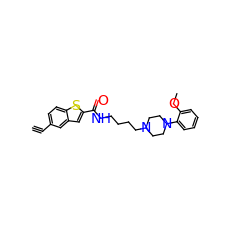

In [19]:
#test nums 78, 89, 2 is predicted to interact with target cpd, sample 0 is random for single target dataset with target 1. class 0 interacts, class 1 is random
# 78 is predicted to interact with target for dataset with target 2. 0 interacts with random
# for dual target Q9Y5N1_P31645 sample 0 has class 0
# for dual target P27338_P29274 sample 0 is class 0
# for dual targe P27338_P22303 sample 4 is class 0

#uncomment the below to choose by index and not by smile
# test_set_index = 89 #112 #458 #89 #121
#
test_cpd = test_data[test_set_index].to(device)

print(test_cpd.smiles)
mol_test = data.Molecule.from_smiles(test_cpd.smiles, with_hydrogen=False)
mol_test.visualize()

model.eval()
# all nodes belong to same graph
batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
out = model(test_cpd.x, test_cpd.edge_index, batch=batch)
out_prob = F.softmax(out, dim = 1)
target_class = torch.argmax(out_prob[0]).item()
print(out)
print(out_prob)
target_class

Creating folder and saving smiles

In [20]:
# if SAVE:
    
#     if DATASET_TYPE == "dual":
#         FOLDER_NAME = "../results/explanations/" + DATASET_TYPE + "/" + TARGET_CPDS
#     else:
#         FOLDER_NAME = "../results/explanations/" + DATASET_TYPE + "/" + TARGET_CPDS +"/Target " + str(TARGET) + " vs Random"

#     CPD_FOLDER_NAME = FOLDER_NAME + "/" + test_cpd.smiles

#     if not os.path.exists(FOLDER_NAME):
#         os.mkdir(FOLDER_NAME)

#     if not os.path.exists(CPD_FOLDER_NAME):
#         os.mkdir(CPD_FOLDER_NAME)


#     mol_test.visualize(save_file = CPD_FOLDER_NAME + "/" + test_cpd.smiles + ".png")

# mol_test.visualize()

In [21]:
print(test_cpd.edge_index)
print(test_cpd.edge_index.shape)

tensor([[ 0,  1,  1,  2,  2,  2,  3,  3,  4,  4,  5,  5,  5,  6,  6,  7,  7,  7,
          8,  8,  8,  9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 15, 16,
         16, 17, 17, 18, 18, 18, 19, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24,
         24, 24, 25, 25, 26, 27, 27, 28, 28, 29, 29, 30, 30, 30, 31, 31],
        [ 1,  0,  2,  1,  3, 31,  2,  4,  3,  5,  4,  6, 30,  5,  7,  6,  8, 29,
          7,  9, 10,  8,  8, 11, 10, 12, 11, 13, 12, 14, 13, 15, 14, 16, 28, 15,
         17, 16, 18, 17, 19, 27, 18, 20, 24, 19, 21, 20, 22, 21, 23, 22, 24, 19,
         23, 25, 24, 26, 25, 18, 28, 15, 27,  7, 30,  5, 29, 31,  2, 30]],
       device='cuda:0')
torch.Size([2, 70])


### Montecarlo Sampling

See https://christophm.github.io/interpretable-ml-book/shapley.html#estimating-the-shapley-value and https://link.springer.com/article/10.1007/s10115-013-0679-x

Inseatd of randmly sampling sample $z$ from the data (that for use is nonsense) we create a random graph $Z$ according to a problability distribution.
We add an edge according to the probability of an edge to exists in the explained graph G.

Pseudo code:

Output: Shapley value for j-th edge
Required: number of iterations M, graph to explain $G(N_g, E_g)$, edge list E, edge index j, edge_probability_distribution, GNN model

$\forall\space m \in {0,...,M-1}$

* create random graph $Z(N_z,E_z)$, where $N_z = N_g$ and with $E_z$ are such that $z \in E_z | e \sim \mathbf{P}$, where $\mathbf{P}$ is the probablity distrubution of an edge to exist. (can be domain-specific, depends on atoms!)
* Choose a random permutation $\pi$ of the egdes
* Order edges list $E_g$: $E_g^{\phi}: (e_0,...,e_j,...,e_{|E_g|-1})$
* Order edges list $E_z$: $E_z^{\phi}: (z_0,...,z_j,...,z_{|E_z|-1})$
* Constuct the two new edge lists:
    * With index $j: E_{+j} = (e_0,...,e_j,z_{j+1}...,z_{|E_z|-1})$
    * Without index $j: E_{-j} = (e_0,...,e_{j-1}, z_j,z_{j+1}...,z_{|E_z|-1})$
* Compute marginal contribution: $\phi_j^m = \hat{f}(E_{+j}) - \hat{f}(E_{+j})$
* Compute Shapley values as the avb: $\phi_j(G) = \frac{1}{M} \sum_{m=0}^{M-1} \phi_{j}^{m}$

where $\hat{f}$ is the function learned by the GNN

number of max edges in directed graph: n*(n-1)

number of max edges in undirected graph: (n*(n-1))/2

### Define edge probablility
We approximate it by using the graph desinity. This is a rather brutal approximation, a domain-specific approach would work probably better (e.g. atoms involved etc)

In [22]:
E = test_cpd.edge_index
num_nodes = test_cpd.x.shape[0]
max_num_edges = num_nodes*(num_nodes-1)
num_edges = E.shape[1]
graph_density = num_edges/max_num_edges
P = graph_density #this is to be discussed and mention in paper

In [23]:
M = 1000 #200
TOL = 10e-3
phi_edges = []
phi_sum_over_M = []
phi_edges_current = [0] * num_edges
sample_variances = []
variances = []
model.eval()
batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
out = model(test_cpd.x, test_cpd.edge_index, batch=batch)
out_prob_real = F.softmax(out, dim = 1)[0][target_class].item()

# marginal_contrib = 0
from numpy.random import default_rng
rng = default_rng(seed = 42) #to seed or not to seed?
model.eval()

log_odds = False
for i in tqdm(range(1, M+1)):
    
    for j in range(num_edges):
        #marginal_contrib = 0
        
        E_z_mask = rng.binomial(1, P, num_edges)
        #E_z_index = torch.IntTensor(torch.nonzero(torch.IntTensor(E_z_mask)).tolist()).to(device).squeeze()
        #E_z = torch.index_select(E, dim = 1, index = E_z_index)
        E_mask = torch.ones(num_edges)
        pi = torch.randperm(num_edges)

        E_j_plus_index = torch.ones(num_edges, dtype=torch.int)
        E_j_minus_index = torch.ones(num_edges, dtype=torch.int)
        selected_edge_index = np.where(pi == j)[0].item()
        for k in range(num_edges):
            if k <= selected_edge_index:
                E_j_plus_index[pi[k]] = E_mask[pi[k]]
            else:
                E_j_plus_index[pi[k]] = E_z_mask[pi[k]]

        for k in range(num_edges):
            if k < selected_edge_index:
                E_j_minus_index[pi[k]] = E_mask[pi[k]]
            else:
                E_j_minus_index[pi[k]] = E_z_mask[pi[k]]


        #we compute marginal contribs
        
        # with edge j
        retained_indices_plus = torch.LongTensor(torch.nonzero(E_j_plus_index).tolist()).to(device).squeeze()
        E_j_plus = torch.index_select(E, dim = 1, index = retained_indices_plus)

        batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
        
        out = model(test_cpd.x, E_j_plus, batch=batch)
        out_prob = None

        if not log_odds:
            out_prob = F.softmax(out, dim = 1)
        else:
            out_prob = out #out prob variable now containts log_odds
        
        V_j_plus = out_prob[0][target_class].item() #probably the predicted class changes when selecting/deselecing certain edges for class 1: more iterations needed?

        # without edge j
        retained_indices_minus = torch.LongTensor(torch.nonzero(E_j_minus_index).tolist()).to(device).squeeze()
        E_j_minus = torch.index_select(E, dim = 1, index = retained_indices_minus)

        batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
        out = model(test_cpd.x, E_j_minus, batch=batch)

        if not log_odds:
            out_prob = F.softmax(out, dim = 1)
        else:
            out_prob = out
        
        V_j_minus = out_prob[0][target_class].item()

        phi_edges_current[j] += (V_j_plus - V_j_minus)

    #phi_edges.append(marginal_contrib/M)
    phi_edges = [elem / i for elem in phi_edges_current]
    print(sum(phi_edges))
    phi_sum_over_M.append(sum(phi_edges))
    sample_variances.append(np.var(phi_sum_over_M))
    sum_squared = sum([(sum_of_phi - out_prob_real)**2 for sum_of_phi in phi_sum_over_M])
    variances.append(sum_squared/i)
    # if abs(out_prob_real - sum(phi_edges)) <= TOL:
    #     break     

print("Sampling steps before convergence: ", i)         
print("Sum of Shapley values: ", sum(phi_edges))
print("Predicted prob: ", out_prob_real)
print("Variances", sample_variances)

  0%|          | 0/1000 [00:00<?, ?it/s]

0.6717267524242462
0.9083486906462053
0.5643971583106644
0.7458423373401568
0.9864129671387319
1.1237157389106913
1.1430302336156388
1.3974996861692928
1.4431571161199643
1.4929749196323183
1.4806253928571178
1.3918648468611745
1.494017716066986
1.4362709333866208
1.4058158600019748
1.3710227443364473
1.4577188307206337
1.5541546577492102
1.5345584927827391
1.5644052606165852
1.467303461561267
1.4030659915833628
1.4091255788833663
1.418652615829238
1.3585392279622253
1.3680629256322498
1.346314328795318
1.2848473697189098
1.250933807568685
1.2085188727098135
1.2134076504860247
1.2570390135788831
1.2495185757862313
1.2288887975827545
1.1890051814937146
1.1752516137038118
1.1525519268496747
1.1203922889876463
1.1476049283693153
1.1903025016611166
1.2256791245890453
1.2225171951178557
1.2342578626290244
1.258598709665408
1.2501800483604217
1.266002931469151
1.2947142837355388
1.2758401256723007
1.2877310533061526
1.2628003519034983
1.239966597507003
1.240600874010446
1.2337736113637179
1.

In [11]:
variances = [0.10776337425555056, 0.05808166515867048, 0.10197105344956031, 0.09262732953249284, 0.07413878508017233, 0.06433325292528129, 0.05806531020030909, 0.07055789776846023, 0.08453904372547849, 0.10038756780944443, 0.1122614965532711, 0.11570287624043622, 0.12557600114555695, 0.13020145267042943, 0.1325004562664745, 0.13282279490706475, 0.13733360289012028, 0.14676436866318565, 0.1540795477819089, 0.16230323515142603, 0.16497320079087535, 0.16485906353951482, 0.16496883145397273, 0.16539804670420416, 0.16392413917883103, 0.1628297604487881, 0.16124101338903735, 0.1583801914682379, 0.15509010742708662, 0.1513697739272262, 0.14795600087475624, 0.1453970331433274, 0.1428777139143746, 0.1402163124017371, 0.1372307874992342, 0.134271963187044, 0.13127196624776102, 0.12819886958313842, 0.12547036527114822, 0.12323898176463757, 0.12147537355498102, 0.11976200463167183, 0.1182530445519967, 0.11708532231109542, 0.11587431586915875, 0.11489351611381816, 0.11429698331600512, 0.11350095740807072, 0.11287418524020866, 0.11199798133072678, 0.11093103927092651, 0.10991099527592443, 0.10886833641930434, 0.10767162672702747, 0.10663716637213849, 0.10552953426123987, 0.10461337095749423, 0.10386920625452443, 0.10305443589662969, 0.10221899099866193, 0.10129723943007497, 0.10029598306557518, 0.09931708453308481, 0.0982615307425645, 0.09720546002683692, 0.09605940396065744, 0.09499722970813387, 0.09389466826958497, 0.09280497275633674, 0.09183000967833921, 0.09084480012553885, 0.0899357401986321, 0.08905558346826278, 0.08815738246966683, 0.08725189840658255, 0.08634945665057571, 0.08545961336267953, 0.08457780541352011, 0.08368842598642574, 0.08284591780236591, 0.08201310797302276, 0.08119649283507896, 0.08036523891788092, 0.07950256135097546, 0.07869416014730277, 0.07792036969371854, 0.0771998193758673, 0.07647296393506009, 0.07572207605601353, 0.07500065841904123, 0.07430653228260688, 0.07363944292662572, 0.07294674671826615, 0.07224939024901848, 0.07154391502229757, 0.07085246137409043, 0.07015653761588249, 0.06946183487793327, 0.06878444874958554, 0.06811485805214809, 0.06745197155244605, 0.06679792300574326, 0.06615193473782353, 0.06552106263990022, 0.06489763742716362, 0.0642854045417753, 0.06368462531108808, 0.06309551336315301, 0.06251690672053016, 0.06195112085066458, 0.061396024705482284, 0.06085022162806545, 0.06031493792352652, 0.05979267901782609, 0.059275333256717196, 0.05877055272931366, 0.05827633487739173, 0.05779028268410486, 0.05731471048362619, 0.05683788256473236, 0.05636815767183198, 0.05590737190552115, 0.055453563105381465, 0.05500718134143109, 0.05456877522039015, 0.05413574752334922, 0.05370954318303392, 0.05329001654865689, 0.052876922403041975, 0.052470323031165944, 0.052069804545313556, 0.05167555999781672, 0.05128714137228876, 0.0509044205943158, 0.050527531142699936, 0.05015608121949949, 0.049790699863502645, 0.049431891785514145, 0.049078960079307066, 0.048733879383704076, 0.04839388786924753, 0.048058355653319555, 0.04773072023048922, 0.04740759880579584, 0.047086090012345864, 0.046766762616410135, 0.04645127675955608, 0.046139393288282024, 0.04583440884038242, 0.0455361066345653, 0.04523967333669753, 0.044950414802956196, 0.04466904922801076, 0.04439489168193618, 0.04412670296941905, 0.04386747232727819, 0.04361067643778564, 0.04336168471423683, 0.043116175873537534, 0.04286788720665673, 0.04262331166611551, 0.0423827036823159, 0.04213755322457602, 0.04189387701320836, 0.0416526645439512, 0.041411202233655346, 0.041167627553546304, 0.04092717312809121, 0.04068698996386413, 0.040454715557630846, 0.04022471358883197, 0.039995566093962605, 0.039768372845606526, 0.039541455338518265, 0.03931734306579742, 0.03909498744189742, 0.038874934296111434, 0.03865669979628444, 0.038440841212930586, 0.038227792275026914, 0.03801706188014454, 0.03780843082170283, 0.03760310430981863, 0.03740092038634458, 0.037201448133556796, 0.0370044868374654, 0.036808429616212744, 0.036613511535519304, 0.036420860091474196, 0.036230318989669184, 0.03604264941528678, 0.03585842392475088, 0.035675896802067224, 0.03549421822407602, 0.03531454249707783, 0.03513807895273724, 0.03496465975055946, 0.03479552956713415, 0.03462918694463324, 0.034468033838498724, 0.03430331819805701, 0.034139348474307746, 0.033976396024213595, 0.03381537156074872, 0.03365865973967743, 0.03350207088102681, 0.033347689796081215, 0.033193043753595566, 0.033041038699988895, 0.032890940677910915, 0.032741599050850174, 0.03259107852905567, 0.032441572767698205, 0.03229231241749141, 0.032143983120491416, 0.03199721905649227, 0.0318527326902799, 0.03171039709316665, 0.031570800032645334, 0.03143426200361195, 0.03130132820009687, 0.031168060902184363, 0.031034394998230713, 0.03090311202407207, 0.030773147829166604, 0.030646641945088576, 0.03052182389847392, 0.030398122627201565, 0.03027826148294876, 0.030158083686397167, 0.030038748513593023, 0.029918992067711012, 0.02980013254031588, 0.02968423501563521, 0.029571202508989838, 0.02945797799805089, 0.029346188716975332, 0.02922916630927944, 0.029110938981595957, 0.02899354604449152, 0.02887595320186984, 0.02875899978264698, 0.028642875270041702, 0.028526577615303944, 0.02841263425748887, 0.02829774603967926, 0.028184420516861014, 0.028072158514868464, 0.027959812412046623, 0.027848710558540993, 0.02773823036771016, 0.02762884685977862, 0.02752058885685333, 0.027412557195362265, 0.027305516913457374, 0.027199315877416263, 0.02709478359727223, 0.026991687401283295, 0.02688947753697432, 0.02678875873012569, 0.02668971941295444, 0.026592743315107067, 0.026495080603204012, 0.026397410443716726, 0.026300678564419217, 0.026203612900113533, 0.026107664331427128, 0.026011326044660988, 0.02591549443436844, 0.02582035394503741, 0.025726311127474095, 0.025633107218793673, 0.025540723992596936, 0.025448939386470686, 0.02535875046363928, 0.02526904628759851, 0.02518043716136578, 0.025092701413094134, 0.025004070290336123, 0.02491602635598303, 0.024828638908307037, 0.024742572114991798, 0.024656063827225377, 0.024570623248538363, 0.02448534285493818, 0.024400483397648897, 0.024316207395456636, 0.02423295282668357, 0.024150094178902723, 0.024067655792830205, 0.02398608683096365, 0.02390549501098954, 0.02382606736131447, 0.023746991119882863, 0.023668173757631448, 0.023589610374154916, 0.023511532295234276, 0.023433942745873536, 0.023357282220726513, 0.023280375015768694, 0.023203779156034, 0.02312759141389025, 0.023051753230867486, 0.02297617555164239, 0.022900887959947862, 0.02282623355131634, 0.022752066739908185, 0.022678219999065944, 0.022604828857675948, 0.022531931513721806, 0.022459495462235236, 0.022387577225852343, 0.022316059783179548, 0.022244991500348695, 0.022174447079441283, 0.022104311016972668, 0.022034583393129345, 0.02196529226181097, 0.02189645544614344, 0.021828078870277517, 0.021760082245437008, 0.021692504703523997, 0.021625352477474886, 0.021558611970269627, 0.021492279888352124, 0.021426361918238417, 0.02136083798096031, 0.02129571347728981, 0.02123120188589586, 0.021167157684865517, 0.021103501464531077, 0.021040076992819946, 0.020976958739289425, 0.02091425448413188, 0.020851935627226627, 0.02079015019088147, 0.020728839524924852, 0.020667717550475674, 0.020607141373871755, 0.020546924621573436, 0.0204869261222501, 0.020427222178617956, 0.02036781916337208, 0.020308793033086837, 0.02024997046336792, 0.020191445645387707, 0.020133306150101105, 0.020075467646363948, 0.02001795514237085, 0.019960761006380487, 0.019903902616559548, 0.01984735749400556, 0.01979113757250122, 0.019735293417753645, 0.019679710040742232, 0.01962444594775602, 0.019569546720562485, 0.01951496665807644, 0.01946066442455313, 0.019406625673653238, 0.019352868144020673, 0.01929943422505541, 0.019246452887362934, 0.019194002717123328, 0.019142000704229733, 0.01909031866248024, 0.019038911215644105, 0.01898806264210505, 0.018937171626196996, 0.01888633232949883, 0.018835703279885565, 0.018785294360289043, 0.018735096316519432, 0.01868517373524692, 0.01863550922744611, 0.018586226449196077, 0.018537119200693408, 0.01848824252093976, 0.01843976857692725, 0.018391678571220357, 0.018343884937438812, 0.0182963648057066, 0.018249273973099348, 0.018202454480714107, 0.018155876051441533, 0.018109728061407548, 0.018063609712908782, 0.018017951696194308, 0.017972538193188257, 0.017927267900608813, 0.01788230193162797, 0.017837656581764828, 0.017793783447132915, 0.0177501155617645, 0.017705818426799656, 0.017661914485436362, 0.01761804699794993, 0.017574400564690493, 0.017530902879714427, 0.017487551765784533, 0.017444555513966422, 0.01740178828091244, 0.017359411927040345, 0.017317420883334985, 0.01727514989309315, 0.017233092616121805, 0.017191278923448478, 0.01714987734765597, 0.017108149673486273, 0.017066567468746855, 0.0170252805350777, 0.016984235749969656, 0.016943370782549372, 0.016902769073413645, 0.01686240854829274, 0.01682219055335132, 0.016782175506136428, 0.016742564860716316, 0.0167029440752186, 0.016663804498201436, 0.01662456868143762, 0.016585379547906346, 0.016546295915658253, 0.016507382807257116, 0.016468700893373687, 0.016430093772887552, 0.01639179900742131, 0.01635368988617753, 0.016315677624465126, 0.01627777498181351, 0.016240022826423294, 0.016202432714010864, 0.016165015410372297, 0.0161277899238795, 0.01609075507462285, 0.016053985828668703, 0.01601727079259773, 0.015980716856431546, 0.015944365170509504, 0.01590817853339992, 0.015872208736249636, 0.015836412489711658, 0.015800809776493577, 0.01576530393801367, 0.015729945443681354, 0.01569470397674802, 0.01565961525389208, 0.015624711690267143, 0.015589979116058104, 0.015555424452514609, 0.015520986010193426, 0.015486738334123586, 0.015452669489349357, 0.015418789433209002, 0.015385059885070038, 0.015351363793656994, 0.015317812504790917, 0.015284374980503682, 0.01525111382974733, 0.015217963426356992, 0.015185000866020804, 0.015152179058680148, 0.015119493413803477, 0.015086923297227064, 0.015054490404991724, 0.015022199843675733, 0.014990057152089077, 0.014958028906162624, 0.014926142405507005, 0.014894402504843652, 0.014862851939088007, 0.014831472436940397, 0.014800126813011119, 0.014768984134280287, 0.014737935731764013, 0.014706998539582527, 0.014676234545726918, 0.014645648472874279, 0.01461519301408912, 0.014584981135063107, 0.014554949852554051, 0.014525075481422144, 0.014495336336412264, 0.014465888532781277, 0.01443660091527868, 0.014407458510489034, 0.014378423220113358, 0.014349705744451746, 0.014321026865926493, 0.01429265162467437, 0.014264187436134786, 0.014235996926428898, 0.01420787858594698, 0.014180009551107625, 0.014152583260158882, 0.014125149704750048, 0.01409766873451435, 0.014070205673762513, 0.014042899960684717, 0.014015682102739912, 0.013988688704170782, 0.013961698045187754, 0.013934893966583, 0.013908398704644574, 0.013882081159969502, 0.013856058029344483, 0.01383027012855329, 0.013804364446256745, 0.013778376515721235, 0.013752360345718721, 0.013726523565895335, 0.013700814643104218, 0.013675195713723748, 0.013649631150195218, 0.013623892769651222, 0.013598342106559289, 0.01357284071585267, 0.013547279072527825, 0.013521807048705536, 0.01349648748201556, 0.013471177283578753, 0.01344610698704496, 0.013420973167219423, 0.013395981916723572, 0.013370920671822353, 0.013345911463219546, 0.013321109810128507, 0.013296487335150509, 0.0132720286259974, 0.013247644820777078, 0.013223305550939639, 0.01319886894322867, 0.013174589734823007, 0.013150375398070017, 0.013126232135099386, 0.013102282142882036, 0.013078556930901078, 0.01305493627798605, 0.013031717519891652, 0.013008750714529829, 0.012985928646606157, 0.012963140508652344, 0.01294054220626214, 0.012918113208581942, 0.012895554383415497, 0.01287330769147391, 0.01285076691005807, 0.01282835582018093, 0.012806085674894052, 0.012784050050551032, 0.012761768274566616, 0.012739360177377592, 0.012717128488382006, 0.012695145188574144, 0.01267307530553805, 0.012651151239280775, 0.012629321760291376, 0.01260752796183818, 0.01258569766543781, 0.012564027034860592, 0.01254220232502642, 0.01252041147932747, 0.012498873424671932, 0.012477434095790368, 0.012456159636923564, 0.012434877953798239, 0.012413552741805773, 0.012392474341929628, 0.012371474964425677, 0.012350693739182853, 0.012330193332181839, 0.012309918792496561, 0.012289889598166827, 0.01226966898943909, 0.012249586769876732, 0.01222979752755187, 0.012210062820758922, 0.01219042579007446, 0.012170989778024941, 0.01215174295350463, 0.012132503119981491, 0.01211317267573874, 0.012093812075332402, 0.012074699006647897, 0.01205567162753297, 0.012036691656799454, 0.012018012836834688, 0.011999602995423036, 0.011981285219573494, 0.011962662842438394, 0.011943979038579543, 0.011925341282929628, 0.011906713805309955, 0.011888404812550631, 0.011870315744369628, 0.011852208110731358, 0.011834187097136259, 0.01181633133809449, 0.01179869076654663, 0.01178143671453705, 0.011764163160783082, 0.011746581172934164, 0.011728960378505975, 0.011711430033124944, 0.011694132330524526, 0.011676650848110717, 0.01165920572789574, 0.011641824524176801, 0.011624533226819899, 0.011607242890363212, 0.011589618809815485, 0.011572125811574541, 0.01155473391194765, 0.01153747471018557, 0.011520241635808195, 0.0115029382856056, 0.011485725967068459, 0.011468753170491766, 0.01145165923509965, 0.011434766603046867, 0.011417768010640612, 0.011400801151790346, 0.011383986242826778, 0.011367313138557997, 0.011350417526377636, 0.01133337099683731, 0.011316400201306176, 0.011299277246938869, 0.011282230482643986, 0.011265269473464234, 0.011248473865231775, 0.011231797177617176, 0.011215309659636212, 0.011198985674836388, 0.011182657112182194, 0.011166455323585091, 0.011149944453796953, 0.011133477678998712, 0.011117092753519736, 0.011100818556169052, 0.011084563610624156, 0.011068530146583384, 0.011052491577178379, 0.011036491116626005, 0.011020440739190944, 0.011004467389059856, 0.010988629036200893, 0.010972907047475519, 0.010957148123886049, 0.0109416781447746, 0.01092627153850715, 0.01091110544173359, 0.010896163119547707, 0.010881377610945457, 0.01086672287373615, 0.010851941321231443, 0.010837530348143882, 0.010823037955397014, 0.01080845814436493, 0.010793935620424982, 0.010779629574794537, 0.010765457989499237, 0.010751309068840392, 0.010736887361942336, 0.010722613741887384, 0.010708153077276041, 0.010693882153104316, 0.010679562899902925, 0.010665238428527738, 0.010650913478092104, 0.0106367015927613, 0.010622448668869367, 0.010607840015838975, 0.010593334203633285, 0.01057892871084496, 0.010564283270446907, 0.01054983782265076, 0.010535489658692445, 0.010521319177512527, 0.010507343362401422, 0.010493356850757985, 0.010479540998583644, 0.010465576420263543, 0.01045174513605498, 0.010437733406423677, 0.010423599546109162, 0.010409485705453055, 0.010395364056479785, 0.010381249471192493, 0.010367171556330244, 0.010353219391083947, 0.010339394983726019, 0.010325469872929798, 0.010311668597033868, 0.010297992609246652, 0.01028447544130604, 0.010271009040147399, 0.010257652065850064, 0.010244299535303076, 0.010230741905600764, 0.010217123848032007, 0.010203384979594199, 0.010189772100537346, 0.010176263750961942, 0.010162748183012193, 0.010149372164817472, 0.010136107526632646, 0.010122872140304282, 0.010109696980686051, 0.010096488364174082, 0.010083178072502495, 0.010069995843226202, 0.010056887538524014, 0.010043450778619187, 0.010029946077792179, 0.010016350971624274, 0.01000272620365752, 0.009989154446589087, 0.0099756399364726, 0.009962168242734982, 0.009948781631584708, 0.009935375146417102, 0.009922041961463993, 0.009908743864378827, 0.009895519269475968, 0.009882426102935367, 0.009869416650172245, 0.009856475015237455, 0.009843620318637062, 0.009830674004442224, 0.009817606477563452, 0.009804585325532283, 0.00979155359534985, 0.009778528469594016, 0.009765580923094635, 0.009752626417548873, 0.00973976696792598, 0.009727008806733202, 0.009714174748378806, 0.009701390530771892, 0.009688755142860116, 0.009676214392476894, 0.009663745345127287, 0.00965121647579095, 0.009638812959219987, 0.009626208992672183, 0.009613666608931488, 0.009601176717369557, 0.00958871451962793, 0.009576362786187422, 0.009564128625371777, 0.009551908176686143, 0.009539742275810144, 0.009527558867599213, 0.009515523155766113, 0.009503489715463964, 0.00949157998097236, 0.009479778106311395, 0.009467926939237023, 0.009456164127371856, 0.009444365001081905, 0.009432588948597062, 0.009420906052148773, 0.009409166976261726, 0.009397568954911308, 0.009385881408265635, 0.009374347970631882, 0.00936290747512106, 0.009351541392646018, 0.009340269957598658, 0.009329045178973846, 0.009317570350979779, 0.009306105613718032, 0.009294683742795259, 0.009283366190032701, 0.009272070308288196, 0.009260764611110927, 0.009249557969340303, 0.009238214641721304, 0.00922687209100086, 0.009215609399753265, 0.009204361198300403, 0.009193201549570318, 0.009182067229205039, 0.009170976449225533, 0.009159999898177, 0.009149031205183978, 0.009138110466069082, 0.009127132810515472, 0.009116222120157872, 0.009105303512961006, 0.009094448443280482, 0.009083653556795149, 0.009072876982850165, 0.009062064310138137, 0.009051239992223513, 0.009040465182861585, 0.009029653431676691, 0.00901890136959958, 0.009008187991665428, 0.008997436666227062, 0.008986733855156333, 0.008975993787009801, 0.008965274433902945, 0.008954635634962084, 0.008944077539785116, 0.008933600711361676, 0.008923285951384995, 0.008913028726084809, 0.008902862362390079, 0.008892754421315218, 0.00888271655659225, 0.008872769144971461, 0.008862787445667805, 0.008852756937104342, 0.00884272364437314, 0.008832724997010844, 0.00882282765193226, 0.008813010590592899, 0.008803117579801487, 0.00879322402419752, 0.008783321372739746, 0.008773429016667358, 0.008763513121987938, 0.008753710612739529, 0.008743911351985255, 0.008734103546393503, 0.008724318878506405, 0.008714520355372405, 0.008704823071662999, 0.008695073994776323, 0.008685315370088563, 0.008675587286872706, 0.008665938148684892, 0.008656253737940272, 0.008646545844681275, 0.0086369143505433, 0.008627299635470426, 0.008617643207629398, 0.008608025807167697, 0.00859846403117186, 0.00858895379990272, 0.008579529506222988, 0.008570143648621253, 0.008560796610952152, 0.008551556062427655, 0.008542294916194324, 0.008533046127459795, 0.008523621112794396, 0.008514270612804803, 0.008505000773025524, 0.008495836483030282, 0.00848667765350214, 0.00847760623769205, 0.008468626658386758, 0.008459724254801638, 0.008450871280759132, 0.008441962293541144, 0.008433128636869982, 0.008424168784906953, 0.008415177926271411, 0.008406228528121867, 0.008397234327849303, 0.008388331986160524, 0.008379493033381839, 0.008370710014508778, 0.008361950036759332, 0.008353284387399967, 0.008344679654090043, 0.008335950341385352, 0.008327182123754115, 0.008318301990037018, 0.008309519948132971, 0.008300768741956111, 0.008291997273370974, 0.008283187027376852, 0.008274482367026027, 0.0082657907748126, 0.008257043709831267, 0.008248341552628371, 0.008239604440106588, 0.008230928555479938, 0.008222223151993125, 0.008213609403105159, 0.00820499674034761, 0.008196409676181593, 0.008187913744640533, 0.0081794781286202, 0.008171069951013354, 0.008162757789328243, 0.00815449295709811, 0.008146205676301026, 0.008137810904562155, 0.008129551988521057, 0.008121289747319153, 0.008113123929577283, 0.008104990673559862, 0.008096811296353331, 0.008088719624360328, 0.008080720193713116, 0.008072681517642804, 0.008064610816772122, 0.008056521135667813, 0.00804847706846479, 0.008040339412690008, 0.008032240291649255, 0.008024168557999485, 0.008016050275810751, 0.008007882574186628, 0.007999747333788203, 0.007991582420272345, 0.007983455594611994, 0.007975308666883809, 0.007967234190325367, 0.007959191568087864, 0.007951178633700274, 0.007943240787909986, 0.007935394188985917, 0.007927598651160762, 0.007919830222168512, 0.007912133418440551, 0.007904496700958632, 0.007896804049934267, 0.007888946984362908, 0.007881150586775448, 0.007873448704153106, 0.00786574714200675, 0.007858076357558943, 0.007850467204512584, 0.007842913575303952, 0.007835467951915484, 0.007828082065167507, 0.007820706438896602, 0.007813497754645122, 0.0078063736872960865, 0.007799222603684168, 0.00779208729689516, 0.007785024223626971, 0.007778145845543973, 0.007771280049881885, 0.007764365510318494, 0.007757575965344812, 0.007750911438682507, 0.007744266546732982, 0.007737585409679923, 0.007730798479863904, 0.007723959779491993, 0.00771720124356369, 0.007710432657474027, 0.007703727419449098, 0.007697096629479503, 0.0076905825488029255, 0.007684064909144453, 0.007677506273417384, 0.007670955436470958, 0.007664279463310375, 0.007657801141785028, 0.007651322516319044, 0.007644908807513275, 0.007638406940810883, 0.0076320112158933025, 0.007625695763168223, 0.0076193634468133, 0.007613019307615556, 0.007606716447335497, 0.007600251816674489, 0.0075936255265107, 0.007587050727700086, 0.007580588143515063, 0.007574119662605693, 0.007567568588724003, 0.007560923185800493, 0.007554249469277028, 0.007547484653107097, 0.007540845719973681, 0.007534274440067302, 0.007527677775500748, 0.00752103459998147, 0.007514430738947994, 0.007507909725816468, 0.007501382795361996, 0.0074949301281779564, 0.0074884301025692195, 0.0074819222220364745, 0.007475427934974678, 0.007469026812844477, 0.007462658208970732, 0.007456390171080422, 0.0074502175488823435, 0.007444059842603544, 0.007437932268376068, 0.007431829980873311, 0.007425747180325267, 0.00741973976722199, 0.007413821721289578, 0.0074079583848820725, 0.007402182252526217, 0.007396396235748914, 0.00739061281212648, 0.007384603725546197]

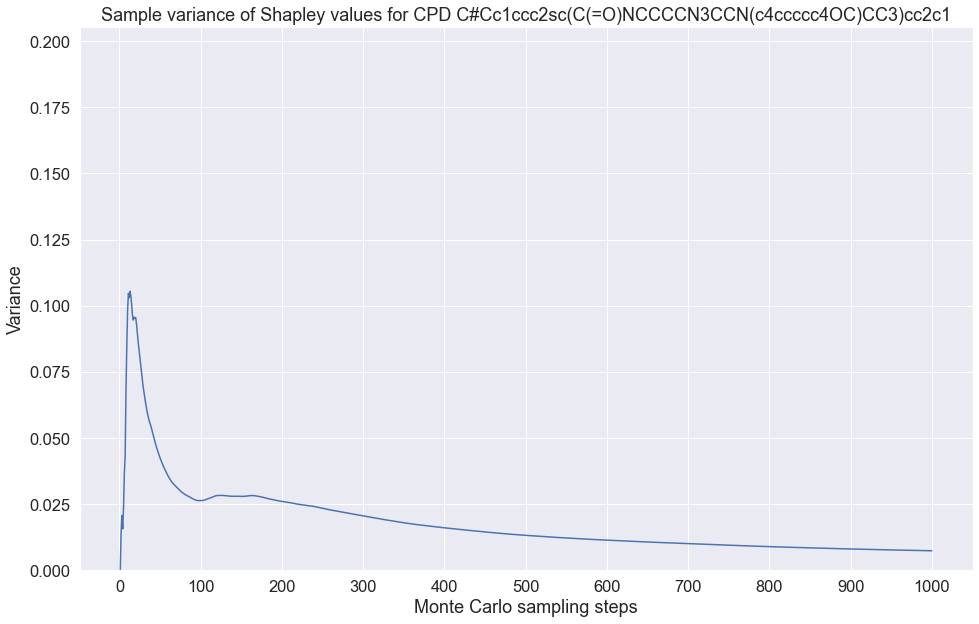

In [24]:
VARIANCE_FOLDER = "../results/variance_convergence_study/" + test_cpd.smiles + "/"
if not os.path.exists(VARIANCE_FOLDER):
    os.makedirs(VARIANCE_FOLDER)

figure(figsize=(16, 10))
sns.set(font_scale=1.5)

sns.lineplot(x=range(1, M+1), y=sample_variances)

plt.xlabel("Monte Carlo sampling steps")
plt.ylabel("Variance")
plt.title("Sample variance of Shapley values for CPD " + str(test_cpd.smiles))
plt.ylim(0, max(sample_variances)+0.1)
plt.xticks([0,100,200,300,400,500,600,700,800,900,1000])
# plt.xticks(ratios)
# plt.yticks(precision_folds)
plt.savefig(VARIANCE_FOLDER + "sample_variance_sampling_steps_" + str(M) + ".png")
plt.show()
# plt.clf()

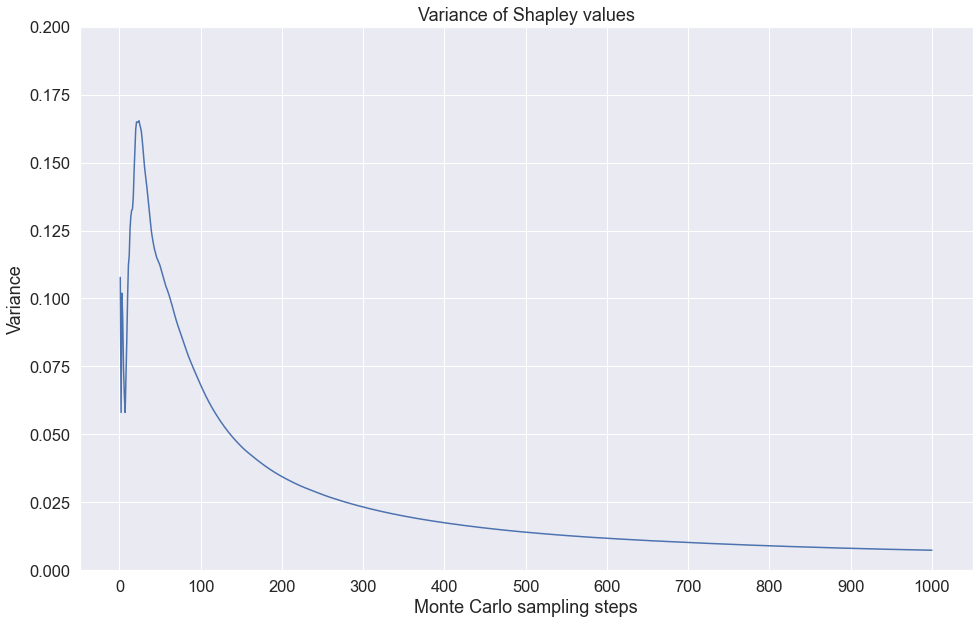

In [46]:
from tkinter import font
import matplotlib
import seaborn as sns

# matplotlib.rcParams.update({'font.size': 22})
# matplotlib.rcParams.update({'font.family': "arial"})

figure(figsize=(16, 10))
# 
sns.set(font = "arial", font_scale=1.5)

M = 1000
sns.lineplot(x=range(1, M+1), y=variances)

plt.xlabel("Monte Carlo sampling steps")
plt.ylabel("Variance")
plt.title("Variance of Shapley values")
plt.ylim(0, 0.2)
plt.xticks([0,100,200,300,400,500,600,700,800,900,1000])
# plt.xticks(ratios)
# plt.yticks(precision_folds)
plt.savefig("variance_sampling_steps_revision" + str(M) + ".png")
plt.show()
# plt.clf()

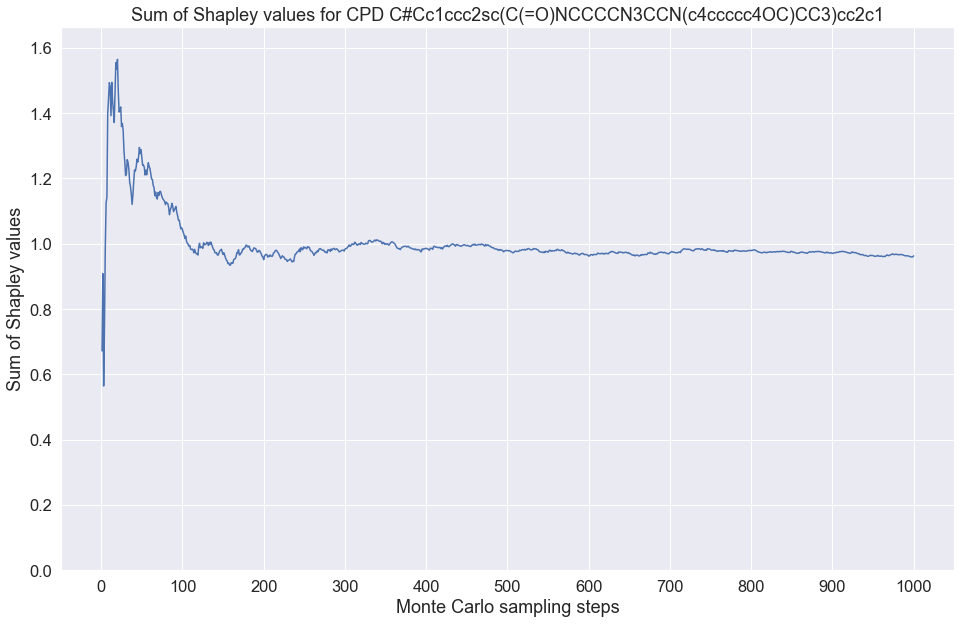

In [26]:
figure(figsize=(16, 10))
sns.set(font_scale=1.5)

sns.lineplot(x=range(1, M+1), y=phi_sum_over_M)

plt.xlabel("Monte Carlo sampling steps")
plt.ylabel("Sum of Shapley values")
plt.title("Sum of Shapley values for CPD " + str(test_cpd.smiles))
plt.ylim(0, max(phi_sum_over_M)+0.1)
plt.xticks([0,100,200,300,400,500,600,700,800,900,1000])
# plt.xticks(ratios)
# plt.yticks(precision_folds)
plt.savefig(VARIANCE_FOLDER + "sum_of_shapley_values_sampling_steps_" + str(M) + ".png")
plt.show()
# plt.clf()

In [39]:
mse = [0.10776337425555056, 0.008399956061790394, 0.18974983003134, 0.06459615778129041, 0.00018460727089027526, 0.015305592150826119, 0.020457653850475953, 0.1580060107455182, 0.1963882113816245, 0.24302428456513786, 0.23100078399153778, 0.1535580527992527, 0.2440535000070056, 0.19033232249377194, 0.1646865066111051, 0.1376578745159188, 0.2095065306190091, 0.3070873868052967, 0.28575277191892734, 0.31855329517225145, 0.21837251357986145, 0.16246218126094353, 0.1673837255720468, 0.17526999745952723, 0.12855035856987576, 0.13547029219771428, 0.11993358983551812, 0.08113799960665286, 0.06296775427485127, 0.04348010243127369, 0.045542809300657724, 0.06606903346903246, 0.062259498587884925, 0.05239006248469998, 0.03572294081413566, 0.030713112260387133, 0.023272076433573614, 0.014494292992102562, 0.02178720141552056, 0.03621502501072191, 0.05093104516871848, 0.04951387877599559, 0.05487672120564131, 0.0668732659523405, 0.06259003242394534, 0.07075752712349183, 0.0868564746166049, 0.07608773973515427, 0.08278912118283009, 0.06906398976611441, 0.057583936280913454, 0.05788875153081815, 0.05465007587505926, 0.044246013036353365, 0.05077630720813368, 0.044609768161815055, 0.05330822594773878, 0.0614518181852459, 0.055797755138733765, 0.05292774201856395, 0.04599214531485828, 0.039219344831087244, 0.038625375518682906, 0.031761641939784, 0.029616934220271642, 0.021565759658991275, 0.02489372904157876, 0.02002305188680802, 0.01870567785545753, 0.024557557296508787, 0.021880131429513817, 0.025392485388252613, 0.02568429888167219, 0.022588709572161827, 0.02024607773834673, 0.018666324950062887, 0.01783152348256919, 0.01667859332824453, 0.014316830673065791, 0.01628777126163936, 0.015388321625570018, 0.015050666661631589, 0.012202417707641045, 0.007900323297821735, 0.010788459038797063, 0.0121481811390597, 0.015232492040660272, 0.013236540584832807, 0.009643942699915772, 0.010794488728506909, 0.011835180003515135, 0.01293431153234011, 0.00921869554918558, 0.0073952386089861655, 0.005229243710531169, 0.005164364794412756, 0.0033478568279193418, 0.002075669296859622, 0.002400608171509163, 0.0018253790058403469, 0.001163321582240799, 0.0007390197887616793, 0.0002611314100109235, 0.0005412365537986793, 6.141530255692519e-05, 9.515760015795938e-07, 2.0268582427561645e-06, 6.0534934100415324e-05, 2.7389317263471647e-05, 0.00028046103531542774, 0.0003354487354301638, 0.0002660800347960391, 0.0003631630151670625, 0.0007774226736777372, 0.000297916490303058, 0.0007207920779073675, 0.000947064054446997, 0.0009221760695413675, 0.0011971908271435452, 9.53602163663578e-05, 1.1705237862946344e-06, 0.00015229418191079524, 8.888948833956002e-05, 0.00010222437553516881, 0.00020641621131387846, 7.285393233590805e-06, 7.796303304933415e-06, 1.0133982774380088e-05, 8.717643327929964e-07, 1.9004059157394244e-05, 2.401384504122244e-06, 2.9524275731081082e-05, 1.588280259792064e-05, 2.5571239118730268e-06, 2.434462617525962e-05, 1.034158743892218e-05, 9.883544793200983e-05, 0.00027518510109032985, 0.0003743846227299482, 0.000767662694888341, 0.0007950758453309566, 0.0007483132074750433, 0.0012064901885831315, 0.0012012350746420516, 0.0007888237555478086, 0.00046429020572951054, 0.0003903416588629413, 0.00029252301099616876, 0.0006967105512417585, 0.00108907796781521, 0.0007746786565313347, 0.0012723762080154436, 0.0019014818363044098, 0.002448787132525988, 0.002825641241780168, 0.003686722795444933, 0.0035505176769486785, 0.004269984117071958, 0.0043257790430489065, 0.0033899891726081417, 0.0034912251795208953, 0.0036448182905791902, 0.0024231790707160143, 0.002174654560279951, 0.0020938195857770135, 0.0015699210348385638, 0.0007342306554456176, 0.0007712840770913411, 0.0003362183737139932, 0.0012003409042069247, 0.0011243788930231447, 0.0008113444713004824, 0.000691134128361508, 0.0002847266122491491, 0.0003218076123706093, 0.0001827532593965598, 0.0001455806377779158, 2.9193326905854017e-05, 1.8013375945130006e-05, 9.20323902696283e-05, 8.55908013179372e-05, 4.620924375355261e-05, 0.00023367914689379762, 0.00040126239059334407, 0.0004985536206051296, 0.0005666470605569916, 0.000341786463219546, 0.00016383044584518887, 0.0002023886109950892, 0.0002180507485215917, 0.00038543028263006413, 0.0006713552323936045, 0.0006306892468056828, 0.0004302526717737399, 0.0004574514594285978, 0.0007276878063226027, 0.0009744961237132215, 0.001476883432349532, 0.001693347689452868, 0.0023985657177300166, 0.0013601901097133949, 0.0011814340007064268, 0.001060001105194717, 0.0011274054773790967, 0.0016894482411336665, 0.0014013548576493808, 0.0015451862972898276, 0.0011813129590655547, 0.0014239875498020102, 0.001520454063612519, 0.00137985736809461, 0.0008312484304155412, 0.0007463513599144119, 0.0004998578234445716, 0.00040151356249193887, 0.0004429452966752522, 0.0006436775884087212, 0.0008235725195916699, 0.0011386408389978254, 0.001532433645300942, 0.0020558914267810135, 0.0017159880635187284, 0.0013605643205214003, 0.0016270087866946483, 0.001661168170342129, 0.0021828180275326246, 0.0023129453635617374, 0.0023179340483772807, 0.0029499205933093573, 0.0026373682760826166, 0.002591658768639043, 0.002255253068966624, 0.0022247221846449943, 0.0026801117650392986, 0.0031215959539714023, 0.0028502179273992958, 0.0029639183831434023, 0.001494855685352823, 0.0009728349929269246, 0.0009366340765314561, 0.000653670972666348, 0.0005732257499367872, 0.0005407432195646529, 0.0002662475140282704, 0.0006104549506108751, 0.00015013267632447036, 0.00030634190357283733, 0.0003434440227085299, 9.797891222995617e-05, 0.0001843490356394256, 0.00011818266000161964, 0.00017358636896219038, 0.00023957211968000298, 8.054683812290158e-05, 0.00011728530961519123, 0.00011805168693221751, 0.0003345198803999648, 0.0004959650321273235, 0.0005193325452592051, 0.0007025877563295895, 0.0009394969484293302, 0.0012819817769432172, 0.0009074500846031281, 0.0007101584985604841, 0.0007634624298771814, 0.0004812118591072789, 0.000585345060843366, 0.0002890034781021984, 0.00023262287596613514, 0.00022756231498969486, 0.000334750385378997, 0.00037484796639891004, 0.00041248646708400667, 0.00039174191400412486, 0.0006469856078329168, 0.0006003978763870771, 0.0007243183211322272, 0.0007898991418479025, 0.00036461816360926897, 0.000351768671470233, 0.00036015355902896206, 0.0005578031934096414, 0.00026072667709547455, 0.0003909394801131373, 0.0002657110724866319, 0.00021553807020311004, 0.0002132707684695515, 0.000338891588814313, 0.0002868036180184977, 0.0002429622178712915, 0.00033108788966257574, 0.0004532753985243751, 0.0006331936561937796, 0.0005776523804214165, 0.0004958692557156987, 0.0004134122485779458, 0.00040042093472429186, 0.0003898465857345438, 0.0005124457269140768, 0.0002851207333805321, 0.00022502123562563969, 0.00019508102862180618, 0.00014862195799213585, 7.613874643828664e-05, 1.3460084812462e-05, 5.663891870153122e-05, 5.7022449012006427e-05, 7.270560498842446e-06, 3.573095569544383e-07, 6.652231891477204e-06, 4.319501398461068e-06, 2.100571077232567e-05, 2.6176692676619477e-06, 6.189742923974394e-07, 2.349891451341505e-05, 1.1451339358691074e-05, 6.542586391405108e-07, 3.6338860033780862e-09, 6.348063869547534e-06, 1.595116904763661e-05, 1.1622964739775166e-06, 1.1374944718583792e-07, 2.3356896609536533e-06, 1.4281429709543316e-06, 6.853470812570957e-07, 3.021631283092484e-06, 3.442829746350975e-08, 7.770362067991982e-10, 7.139990868097358e-05, 9.661554588258186e-05, 9.69487541661649e-05, 4.657685643614046e-05, 2.1698567156374566e-05, 3.3737516669458965e-05, 3.7437420871965196e-05, 9.202901525419742e-05, 0.00012845576350092473, 6.961216110184874e-05, 0.00013239368174852657, 0.00013344559244265903, 8.743635231564906e-05, 6.817740005709556e-05, 5.1987949281559665e-05, 6.28303452488196e-05, 1.5006480059938003e-05, 3.8344221368725917e-07, 1.7040780936563154e-05, 5.506849571145967e-06, 3.603752773330612e-06, 7.545743072356328e-09, 3.4661792308548466e-06, 1.9477556164108208e-08, 1.7252029735394356e-06, 2.2306791859461045e-05, 3.194578701424139e-06, 5.6929376509279205e-06, 2.54218396642311e-05, 2.988435055784433e-05, 2.0464823208863014e-05, 6.714100592238792e-06, 1.5747629685879587e-07, 9.789478595378445e-06, 6.720864268665651e-05, 0.00015459092014639787, 0.00021326801096025524, 0.000226373423915273, 0.00022378567361934436, 0.00032663615327043323, 0.00020927777203410793, 0.0001266318478748014, 0.00010295492297676795, 8.358518997961813e-05, 6.142403422490199e-05, 6.405092059923161e-05, 6.098330994266092e-05, 0.00010518460543565028, 7.279376368864498e-05, 6.173425381447892e-05, 0.00011661774019851859, 0.00016556640830761558, 0.00018230410045207198, 0.00019119461573462366, 0.0002605759171280523, 0.00027058889716727964, 0.000269759210773634, 0.00034275189832193786, 0.00026192719238553455, 0.0003482992276929543, 0.0003520990268402632, 0.0003171240872051762, 0.00034557402909870036, 0.000381324785277618, 0.0005955146714225098, 0.000588636611978018, 0.0002527472506508261, 0.0003198576469361933, 0.0002465219533233099, 0.0002467665606936284, 0.000218824259239449, 0.0001904573077565898, 0.0002460547867227841, 0.000252127826265364, 0.00032411767045751314, 0.0003950302700751698, 0.00019766983539244018, 0.00019989544272535392, 0.00021491969807948454, 0.00029943600010517144, 8.325861224944638e-05, 5.944573032531255e-05, 9.763773072475364e-05, 0.00011482907056325092, 0.00010700420539275381, 0.00013426320035888999, 0.0001531511482379085, 0.00013172265266304597, 0.00013591586474032607, 0.00022492572052969456, 0.00014145573717256298, 0.00026432172801032925, 0.0001455256406347953, 8.675433123997313e-05, 5.300310696368369e-05, 4.71379535758907e-05, 6.756940679927714e-05, 2.206756628101794e-05, 7.822891880180212e-05, 8.109511508253654e-05, 4.6429611555937766e-05, 1.7541284271039542e-05, 6.59600863005143e-06, 1.0942642530483356e-06, 7.402385100471477e-07, 9.154272499583762e-06, 1.763049723776078e-05, 5.93638386134688e-05, 9.515065653828145e-06, 6.6467518081033e-06, 2.2326736655005224e-05, 2.224484229281975e-05, 4.5497990124529676e-05, 5.026776646347711e-05, 6.441053410245485e-05, 3.621749141531343e-05, 3.077396013104999e-05, 1.225119141417211e-05, 1.004486014379773e-05, 2.2818749919701523e-05, 2.9785870408848506e-05, 4.038052148467027e-05, 2.36869656614024e-05, 4.103642662523023e-05, 5.35516513969257e-05, 7.112400162836782e-05, 7.18450299805002e-05, 1.9642200722185908e-05, 1.8424781860160147e-05, 3.426381236899789e-06, 1.7506783338282628e-05, 1.92827019207231e-06, 2.2223111374210568e-05, 2.132587463645315e-05, 1.8725480782195585e-05, 6.9593223473991925e-06, 5.628407794204431e-06, 7.088831740650984e-06, 1.1562872706183407e-05, 8.380585098336871e-07, 3.2600986775162273e-06, 8.389093730888191e-06, 3.408603393452974e-05, 5.172692541548384e-05, 4.992318392446752e-06, 3.849709459631375e-05, 2.099293904999581e-05, 1.1832253376324616e-05, 3.257347045775859e-05, 5.609172216498934e-05, 5.748371478418484e-05, 0.00011349108160291751, 0.00013993424820704157, 0.00015550296697521747, 0.00016106844165024033, 0.0002425993790146853, 0.0002613940440216643, 0.00027339218751108556, 0.00026727209753457106, 0.0003642950972463459, 0.0003257341456033303, 0.00041715865238571635, 0.00031673505173790737, 0.00039445666083829994, 0.0003736550688440526, 0.0004405753753051833, 0.0006039955314805386, 0.0005455397773773861, 0.0004671074976080221, 0.0004210644800998231, 0.00044465484794240087, 0.0004339709882827453, 0.0004919894196055434, 0.00043937789469128966, 0.00047924650699517106, 0.0005812819496170206, 0.0006180386437326326, 0.0007143770637097086, 0.000781592328210725, 0.000670183521908385, 0.0005765078036827151, 0.000510129814438786, 0.0005497658559684791, 0.0005635550968432713, 0.0005583038709227019, 0.0005350100600596181, 0.00039436517003736037, 0.0004397506142136856, 0.00041412311123664107, 0.0003319094735833206, 0.00032729870875966094, 0.0003556323699187653, 0.0003098740964385597, 0.00038448249293944004, 0.00030111921828876134, 0.00032555790739333633, 0.00023882834358326374, 0.00021607694674575546, 0.0002754402842422004, 0.00032044302174468527, 0.00035783019315596877, 0.0003486118592260975, 0.00032349253709694275, 0.00022303024870442965, 0.000258050863010555, 0.000244133908726351, 0.0002337297087828328, 0.00028903630660027485, 0.00036184330910799613, 0.00037064566261607866, 0.0005400256651055095, 0.000629642624506687, 0.0006620119678234996, 0.0006347578756400304, 0.0006922623107709439, 0.0007391674682338473, 0.00062355349286916, 0.0007488605833094454, 0.0005435002570092341, 0.000569489657385642, 0.0006020460576845703, 0.0006864922862326879, 0.0005067914831381615, 0.0003924986262253768, 0.0004452361628184633, 0.0005383803948267633, 0.0004463601035430519, 0.00048329446649253487, 0.0004921314421843825, 0.0004683822234092952, 0.0004043922740310856, 0.0004501445421955869, 0.00032036481788989065, 0.0002957470422165099, 0.000394486708259266, 0.0004070919354691012, 0.00045736483604623846, 0.0004107269879890388, 0.00034348275406961316, 0.00044102161215566475, 0.0004438285421808455, 0.0005261765760168633, 0.0006449613416040456, 0.0007331566322028644, 0.0008331904415585522, 0.0006832601884466244, 0.0007223927410825309, 0.0008509831907558815, 0.000842871708020882, 0.0008598590851402487, 0.0009369748134031568, 0.0010078315562439277, 0.0009733996765610148, 0.000882184570699728, 0.0008259426388447338, 0.0009317799635814764, 0.0009436822244155529, 0.0009334087776912852, 0.001072224337482607, 0.0011930260867826499, 0.0012104330200428716, 0.0009940827098642664, 0.0009205347618579971, 0.0009104276938302049, 0.000879247054463664, 0.001031172106271473, 0.0011254092448539663, 0.00107816609596105, 0.0010936629944562405, 0.001156443190158049, 0.0012496289809277978, 0.001446259560798318, 0.0014000309084024902, 0.0011798064757346973, 0.0011212421327357707, 0.0011406317683630009, 0.0012463199598723006, 0.0011003539877568471, 0.0010874628776196397, 0.001091433866780726, 0.001111424433824, 0.001077427988240752, 0.0008389296757013711, 0.0008839038863576261, 0.0009108913402908394, 0.0009575840300302419, 0.0009391339680991992, 0.0008613779110108554, 0.0008829377481889605, 0.0009965376826727662, 0.0008876071627714232, 0.0009782273623749557, 0.0008786407187616716, 0.0008643818057750229, 0.0009251128674878628, 0.0009799691791077085, 0.0008075555258327143, 0.0006792900341335383, 0.0006926821988168184, 0.0005631848586374441, 0.0005768625054580343, 0.000596794699399899, 0.0006672406787825578, 0.000708807292804841, 0.0007951982956669511, 0.0008659032965476157, 0.0008303483894231587, 0.0008783195644259423, 0.0006490312685405773, 0.0006441421325181841, 0.0006635102979337614, 0.0007016064490811374, 0.0006813984618904276, 0.0007910796964492966, 0.0007557300191647551, 0.0007481949814490021, 0.0006839976710123739, 0.0007016565545080658, 0.0007570530893106836, 0.0008007803421584125, 0.0007453656379092492, 0.0009016617014440665, 0.0009119774646643617, 0.0010379764421458858, 0.0011537690543531568, 0.0012264404936753934, 0.001282524738850098, 0.001170024430647778, 0.001383932002703085, 0.0013015359207055829, 0.0012149424852536542, 0.001223592343999198, 0.0013376394587005964, 0.0013980401093058427, 0.0013847235926848112, 0.0011752956885313325, 0.0012449300253991392, 0.0010918111107330831, 0.0011894466547351728, 0.0011286210145748995, 0.0010964915499023485, 0.0010675216366527525, 0.0011147384211234708, 0.001058736737381882, 0.0007908251794145186, 0.0008309225892050809, 0.0008696265715143332, 0.0006786110017602192, 0.000784715112454495, 0.0008217826589139791, 0.0009137329375280851, 0.0010177649019611783, 0.0009825289332205276, 0.0010709456678574954, 0.0009417340059554468, 0.0010049780216061378, 0.0008537103386123858, 0.0007419052306663424, 0.0007273910153642992, 0.0006937912118438208, 0.0006704147935348532, 0.0006674882162398927, 0.0007262253711398253, 0.0007867294993979301, 0.0006892932019451368, 0.0007473844011551714, 0.0008068570849180548, 0.0008900437225799129, 0.0008983938337341689, 0.0009478409806072503, 0.0009242332135056458, 0.0007539587436844952, 0.0006844835499021751, 0.0005724382046904933, 0.0006335310026264315, 0.0006798939994526745, 0.0006477883463889685, 0.0007192793375399184, 0.0007712729681442918, 0.0007654540061523382, 0.0007816839709783063, 0.0007315792571876632, 0.0006328709856757599, 0.0006974308277822786, 0.0007237745905648161, 0.0004630409664777429, 0.00038758968730887814, 0.00029585006157244593, 0.0002473923394616466, 0.00025820462852141747, 0.00027222167283660014, 0.0002760204453874665, 0.0003104216033871446, 0.00026929934057308625, 0.0002954824253189763, 0.0002942196718038731, 0.00032091255980681, 0.00038988036099831745, 0.00042455394414623866, 0.0004479064176464246, 0.00048540119355076927, 0.0003928109564043587, 0.00027831185606045505, 0.0002861231907475758, 0.0002523271018097851, 0.00023111129056751522, 0.00026208179254771956, 0.00023106484141355136, 0.0002752120454772086, 0.00032424400765480426, 0.00024263968283474413, 0.00025385371926331504, 0.00033856808814543504, 0.0003835183585090123, 0.00041171221171962323, 0.0003422665588932146, 0.00041059663042199596, 0.00023625391455852626, 0.00025704833837373036, 0.0002712277206072799, 0.0002669906088888447, 0.00032491443924826145, 0.0003885080136386042, 0.0003743512137747681, 0.0003909848170597511, 0.00035345248476848455, 0.00044059643360981203, 0.00041824228734106716, 0.00048782070531953734, 0.0005457589879602039, 0.0004847422968641037, 0.0005281899217093974, 0.00047702902071923206, 0.0004710130076315383, 0.0005185389585531277, 0.00045225207444493345, 0.0005366806431913196, 0.0004449082243258062, 0.0005397347431774441, 0.0005880474183212844, 0.0006223900518130701, 0.0006725364061790144, 0.0006859656378689158, 0.0004704779675536213, 0.00045532844765048636, 0.0004655775194913697, 0.0005235803518126978, 0.0005177619562965806, 0.0004875436015501281, 0.0005419973135649227, 0.00041310575414048073, 0.0003910250797750161, 0.0004307102266286571, 0.0004195158636163637, 0.0004663562426434042, 0.00046389438319108, 0.00047580494529125025, 0.0005434073250790735, 0.0005276385126695953, 0.0005434887826466476, 0.0004767402342699288, 0.0005076874280104292, 0.0004796038274375461, 0.0005080883259865474, 0.0005341034604110552, 0.000527053844478556, 0.00047680217678783195, 0.00044590725009618497, 0.00046371693076684747, 0.0004126877373171597, 0.00043875583206449346, 0.0004481990222788029, 0.0003963763155342434, 0.0004137821875015229, 0.0003624591334909096, 0.0003576338890974402, 0.00040104128650937616, 0.0004448109223255378, 0.000489277002069428, 0.0005992746502037315, 0.0006251906835336677, 0.0006782741333540467, 0.0007053221506782999, 0.000742008266266014, 0.0007954709088906269, 0.0007476659117955267, 0.0006879229664449514, 0.0006655900684439201, 0.0006738287493766828, 0.0007366967227298799, 0.0007826544149947395, 0.0007007417416354106, 0.0006805084289443854, 0.0006532445259081656, 0.0006419123251648172, 0.0006027318008239002, 0.0006764429920515764, 0.0006595212297101897, 0.0006328561276057049, 0.000632398535876837, 0.0006013432004194357, 0.0006657748765648403, 0.0006033401788363701, 0.0005758982545593377, 0.0005818220512808857, 0.0006282060382349014, 0.0005794551769271866, 0.0005404549734178256, 0.0005849852511964517, 0.0005797831194759812, 0.0005255566768471969, 0.0005390268198017442, 0.0005665721946673767, 0.0005908493025559712, 0.0006442742278887322, 0.0006578656903577551, 0.0006718968182315755, 0.0007432925592281984, 0.0007073652027951154, 0.0006993220693136819, 0.0005312086765366203, 0.0005756961216395724, 0.0006256369606386555, 0.0006970256970786047, 0.0006833548955257754, 0.0007396885516862573, 0.0008000659316670686, 0.0008481691895237153, 0.0008727255003729605, 0.0008069602477258135, 0.0008538512130119348, 0.0007276559486659732, 0.0006830394997043839, 0.0007007967213645345, 0.0006442336928988514, 0.0007056111087437471, 0.0007426378325993249, 0.0007733986893106686, 0.0007758093057389215, 0.0008401663928300259, 0.0008757711410759342, 0.0007501776010096461, 0.0006988327845780309, 0.0005837055224458202, 0.0006515794078027421, 0.0006609657495572825, 0.0006257337299617586, 0.0005742217825196307, 0.0006491998997034834, 0.0006432644036378836, 0.0005771206562202964, 0.0005991453712835471, 0.000550945420937444, 0.0005874741994009973, 0.0005440572766244742, 0.0006076691350308739, 0.0005914028626749796, 0.0005968578892560535, 0.0006605183992619111, 0.0006970867185850342, 0.0007046082361328827, 0.0007732460512643357, 0.0007987922722797055, 0.0007622384861002916, 0.0006496745134888189, 0.0007543399638214378, 0.0007348461128167985, 0.0008047170506030654, 0.0008175932819506349, 0.000759909942095765, 0.0008223981746442364, 0.0008892320418694516, 0.0008378730543608188, 0.00079290933228802, 0.0007596287795809644, 0.000784684384134849, 0.0006838985922872436, 0.0007025357497681506, 0.0007111778713084687, 0.0006527683306293281, 0.0005916094994833028, 0.0006048138116203639, 0.0005615111208420192, 0.0005799174180309487, 0.0005453105787791909, 0.0005952370924679626, 0.0006082348430107532, 0.000619343669055587, 0.0006721740440057007, 0.0007400629756165126, 0.0007712949276670323, 0.0007806439782896404, 0.0008310739887177399, 0.0008710799001101246, 0.000804179805470964, 0.0006368754619982594, 0.0006772792159618097, 0.000749207278487082, 0.0007341005944812945, 0.0007472591744420063, 0.0007891731774914502, 0.0008255920404853742, 0.0009110382006402415, 0.0009518215028009717, 0.0009466227544128036, 0.0010877953480152994, 0.0011524947832974029, 0.001112959426539955, 0.0011134401423839805, 0.0011669245713336266, 0.0013262272036910412, 0.0013242979231826383, 0.0012646983207299659, 0.0013686141451101775, 0.0014729273227918765, 0.001478133438331047, 0.0014305920315920422, 0.0013171498037265405, 0.0012545492276648746, 0.0013168677194598263, 0.0012938130444737116, 0.0013404565337921048, 0.0013978461583633423, 0.0014956918253773584, 0.0014792719542787664, 0.0014271264255206262, 0.0014214569895812713, 0.0012887250949539678, 0.0014645257635527234, 0.001451277945373004, 0.0015005757715862299, 0.0014031167732165767, 0.0014921152950170089, 0.0015565456943667326, 0.0015276751133770107, 0.0015036132601883763, 0.0015307591373594383, 0.0013618832288013903, 0.0011926292282902903, 0.0012292202778363844, 0.0013248066524131456, 0.0013061616614272165, 0.0012130269234834155, 0.001108236947072275, 0.0010673970084696565, 0.0009653185197637991, 0.0010745248480270018, 0.0011272765313468725, 0.0010893331585447208, 0.0010306521176468672, 0.0010558546482084105, 0.0011238378700521754, 0.0011049909499795119, 0.001164863620634382, 0.0011054049547894855, 0.0010846756583481611, 0.0010850494661672964, 0.0011639215145964118, 0.0011832147894583463, 0.0012698367733448915, 0.0013516668171803187, 0.001354088332870951, 0.0013716337831748964, 0.0013844630656420144, 0.001391609036664281, 0.0014543785556673974, 0.001531284064472634, 0.0015739386594145024, 0.0016491544260941221, 0.001627737508777275, 0.0016187560369376201, 0.0013815262318432142]

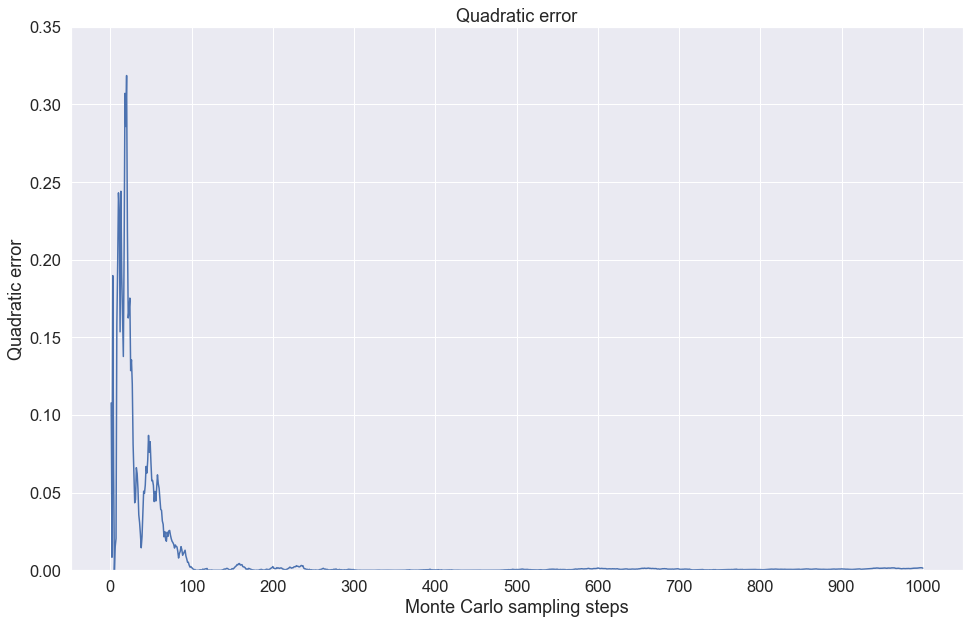

In [45]:
# mse = [(out_prob_real - sum_of_phi)**2 for sum_of_phi in phi_sum_over_M]
 
figure(figsize=(16, 10))

sns.set(font = "arial", font_scale = 1.5)
sns.lineplot(x=range(1, M+1), y=mse)

plt.xlabel("Monte Carlo sampling steps")
plt.ylabel("Quadratic error")
plt.title("Quadratic error")
plt.ylim(0, 0.35)
plt.xticks([0,100,200,300,400,500,600,700,800,900,1000])
# plt.yticks(precision_folds)"
plt.savefig("mse_revision_.png")
plt.show()
# plt.clf()

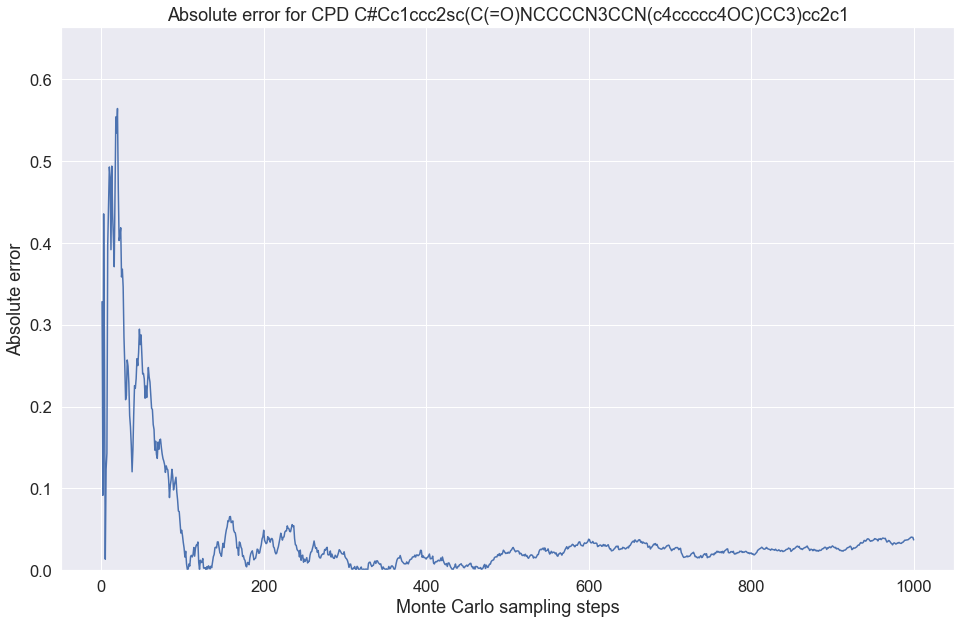

In [48]:
mae = [np.abs(out_prob_real - sum_of_phi) for sum_of_phi in phi_sum_over_M]

figure(figsize=(16, 10))
sns.set(font_scale=1.5)

sns.lineplot(x=range(1, M+1), y=mae)

plt.xlabel("Monte Carlo sampling steps")
plt.ylabel("Absolute error")
plt.title("Absolute error for CPD " + str(test_cpd.smiles))
plt.ylim(0, max(mae)+0.1)
# plt.xticks(ratios)
# plt.yticks(precision_folds)
plt.savefig(VARIANCE_FOLDER + "mae_sampling_steps_" + str(M) + ".png")
plt.show()
# plt.clf()

In [29]:
with open(VARIANCE_FOLDER + "sum_of_phis_over_M_sampling_steps_" + str(M) + ".txt", "w+") as saveFile:
         saveFile.write(str(phi_sum_over_M))

with open(VARIANCE_FOLDER + "mae_M_sampling_steps_" + str(M) + ".txt", "w+") as saveFile:
         saveFile.write(str(mae))

with open(VARIANCE_FOLDER + "mse_sampling_steps_" + str(M) + ".txt", "w+") as saveFile:
         saveFile.write(str(mse))

with open(VARIANCE_FOLDER + "variances_sampling_steps_" + str(M) + ".txt", "w+") as saveFile:
         saveFile.write(str(variances))

with open(VARIANCE_FOLDER + "sample_variances_sampling_steps_" + str(M) + ".txt", "w+") as saveFile:
         saveFile.write(str(sample_variances))


In [30]:
phi_sum_over_M

[0.6717267524242462,
 0.9083486906462053,
 0.5643971583106644,
 0.7458423373401568,
 0.9864129671387319,
 1.1237157389106913,
 1.1430302336156388,
 1.3974996861692928,
 1.4431571161199643,
 1.4929749196323183,
 1.4806253928571178,
 1.3918648468611745,
 1.494017716066986,
 1.4362709333866208,
 1.4058158600019748,
 1.3710227443364473,
 1.4577188307206337,
 1.5541546577492102,
 1.5345584927827391,
 1.5644052606165852,
 1.467303461561267,
 1.4030659915833628,
 1.4091255788833663,
 1.418652615829238,
 1.3585392279622253,
 1.3680629256322498,
 1.346314328795318,
 1.2848473697189098,
 1.250933807568685,
 1.2085188727098135,
 1.2134076504860247,
 1.2570390135788831,
 1.2495185757862313,
 1.2288887975827545,
 1.1890051814937146,
 1.1752516137038118,
 1.1525519268496747,
 1.1203922889876463,
 1.1476049283693153,
 1.1903025016611166,
 1.2256791245890453,
 1.2225171951178557,
 1.2342578626290244,
 1.258598709665408,
 1.2501800483604217,
 1.266002931469151,
 1.2947142837355388,
 1.2758401256723007,

In [31]:
abs(out_prob_real - sum(phi_edges))

0.037168874961235665

In [32]:
print(out_prob)
print(phi_edges)

tensor([[3.5735e-13, 1.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
[0.014991020590014512, -0.004619928615911109, 0.0025550764168126294, 0.025175422707688855, 0.03205613637925543, 0.007650133565253985, 0.007000573949596803, 0.012306293582397463, -0.004308310877035397, 0.00713735958728072, 0.013698149736748202, 0.03710491227267465, -0.008655175816527949, -0.008755916937211906, -0.0024832967037358897, 0.030840267406755557, 0.007403106747150877, -0.010983802083633237, 0.001363476169674036, 0.004466114939006571, 0.034168933110188315, -0.016047325504223678, 0.012218937472603742, 0.0184908285002496, 0.05193956393918747, 0.010916841722671577, 0.018617296717682988, -0.011218666657741431, 0.011191870194500244, -0.003010044461469637, 0.04797574961993411, 0.03344088446183554, 0.06858172688669908, 0.10302208722650504, 0.11744135711843798, -0.011642711221991873, 0.034466963982225984, 0.0073993267283729396, -2.6692858789387685e-05, 0.06318172046281903, -0.0030791567196258632, 0.034534099

In [33]:
# if SAVE:
#     INFO_EXPLANATIONS = "info_explanations"
#     if TRAINING_SET_SPLIT != None:
#         INFO_EXPLANATIONS += "_training_split_" + str(TRAINING_SET_SPLIT)
        
#     with open(CPD_FOLDER_NAME + "/" + INFO_EXPLANATIONS + ".txt", "w+") as saveFile:
#         saveFile.write("Test set index: " + str(test_set_index) + "\n\n")

#     with open(CPD_FOLDER_NAME + "/" + INFO_EXPLANATIONS + ".txt", "a") as saveFile:
#         saveFile.write("Target Class: " + str(target_class) + "\n\n")

#     tagert_compound_sample = "TARGET" if target_class == 0 else "RANDOM"

#     with open(CPD_FOLDER_NAME + "/" + INFO_EXPLANATIONS + ".txt", "a") as saveFile:
#         saveFile.write("Target compound: " + str(tagert_compound_sample) + "\n\n")

#     with open(CPD_FOLDER_NAME + "/" + INFO_EXPLANATIONS + ".txt", "a") as saveFile:
#         saveFile.write("Sum of Shapley Values: " + str(sum(phi_edges)) + "\n\n")

#     with open(CPD_FOLDER_NAME + "/" + INFO_EXPLANATIONS + ".txt", "a") as saveFile:
#         saveFile.write("Shapley values:\n")
#         for phi_val in phi_edges:
#             saveFile.write(str(phi_val) + "\n")
#     with open(CPD_FOLDER_NAME + "/" + INFO_EXPLANATIONS + ".txt", "a") as saveFile:
#         saveFile.write("\nEdge Index:\n")
#         saveFile.write(str(test_cpd.edge_index) + "\n\n")
#         saveFile.write("Edge index shape: " + str(test_cpd.edge_index.shape) +"\n")

In [34]:
# retained_indices_plus = torch.LongTensor(torch.nonzero(E_j_plus_index).tolist()).to(device).squeeze()
# E_j_plus = torch.index_select(E, dim = 1, index = retained_indices_plus)

# batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
# out = model(test_cpd.x, E_j_plus, batch=batch)
# out_prob = F.softmax(out, dim = 1)

# V_j_plus = out_prob[0][0].item()

# # without edge j
# retained_indices_minus = torch.LongTensor(torch.nonzero(E_j_minus_index).tolist()).to(device).squeeze()
# E_j_minus = torch.index_select(E, dim = 1, index = retained_indices_minus)

# batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
# out = model(test_cpd.x, E_j_minus, batch=batch)
# out_prob = F.softmax(out, dim = 1)

# V_j_minus = out_prob[0][0].item()

# marginal_contrib += (V_j_plus - V_j_minus)

In [35]:
# batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
# out = model(test_cpd.x, test_cpd.edge_index, batch=batch)
# out_prob = F.softmax(out, dim = 1)

## Visualize Explanation

In [36]:
# from matplotlib.pyplot import figure
# import matplotlib.pyplot as plt

# important_edges_ranking = np.argsort(-np.array(phi_edges))
# print(important_edges_ranking)
# sorted_phi_edges = sorted(phi_edges, reverse = True)
# print(sorted_phi_edges)
# print(sum(phi_edges))

# threshold = np.median(phi_edges) #to discuss when an edge in important or not
# hard_edge_mask = (torch.FloatTensor(phi_edges) > threshold).to(torch.float) #>=
# print(hard_edge_mask.shape)

# important_edges_index = torch.nonzero(hard_edge_mask == 1)
# print(important_edges_index)

# edge_index = E.to(device)
# important_edges_index = important_edges_index.to(device)

# important_edges = torch.index_select(edge_index, dim = 1, index = important_edges_index.squeeze())
# print(important_edges)

# edges_color = []
# mol = read_smiles(test_cpd.smiles)

# #standard visualization for importan egdes GNNExplainer-like
# for edge in mol.edges:
#     found_from = False
#     found_to = False
#     for i in range(important_edges.shape[1]):
#         if edge[0] == important_edges[0][i] and edge[1] == important_edges[1][i]:
#             found_from = True
#         if edge[1] == important_edges[0][i] and edge[0] == important_edges[1][i]:
#             found_to = True
#     if found_from and found_to:
#         edges_color.append("red")
#     elif found_from or found_to:
#         edges_color.append("orange")
#     else:
#         edges_color.append("black")   

# #visualization for indentifying unimportant edges (edge is important if both directins are above threshold)
# # for edge in mol.edges:
# #     found_from = False
# #     found_to = False
# #     for i in range(important_edges.shape[1]):
# #         if edge[0] == important_edges[0][i] and edge[1] == important_edges[1][i]:
# #             found_from = True
# #         if edge[1] == important_edges[0][i] and edge[0] == important_edges[1][i]:
# #             found_to = True
# #     if found_from and found_to:
# #         edges_color.append("red")
# #     # elif found_from or found_to:
# #     #     edges_color.append("red")
# #     else:
# #         edges_color.append("black")   

# figure(figsize=(16, 12), dpi=80)
# #mol = nx.DiGraph(mol)
# labels = nx.get_node_attributes(mol, 'element') 
# nx.draw(mol, with_labels = True, edge_color = edges_color, pos=nx.spring_layout(mol))

# # if SAVE:
# #     if TRAINING_SET_SPLIT == None:
# #         plt.savefig(CPD_FOLDER_NAME + "/" + test_cpd.smiles + "_GraphSHAPer_MC_" + str(M), dpi=300, bbox_inches='tight')
# #     else:
# #         plt.savefig(CPD_FOLDER_NAME + "/" + test_cpd.smiles + "_GraphSHAPer_MC_" + str(M) + "training_split_" + str(TRAINING_SET_SPLIT), dpi=300, bbox_inches='tight')
    
# # plt.show()

## Visualize Explanation - Moleculized

In [37]:
# test_mol = Chem.MolFromSmiles(test_cpd.smiles)
# test_mol = Draw.PrepareMolForDrawing(test_mol)

# num_bonds = len(test_mol.GetBonds())
# num_atoms = len(test_mol.GetAtoms())

# rdkit_bonds = {}

# for i in range(num_bonds):
#     init_atom = test_mol.GetBondWithIdx(i).GetBeginAtomIdx()
#     end_atom = test_mol.GetBondWithIdx(i).GetEndAtomIdx()
#     bond_type = test_mol.GetBondWithIdx(i).GetBondType()
#     #print("Bond: ", i, " " , init_atom, "-" , end_atom, " ", bond_type)
#     rdkit_bonds[(init_atom, end_atom)] = i

# rdkit_bonds_phi = [0]*num_bonds
# for i in range(len(phi_edges)):
#     phi_value = phi_edges[i]
#     init_atom = edge_index[0][i].item()
#     end_atom = edge_index[1][i].item()
    
#     if (init_atom, end_atom) in rdkit_bonds:
#         bond_index = rdkit_bonds[(init_atom, end_atom)]
#         rdkit_bonds_phi[bond_index] += phi_value
#     if (end_atom, init_atom) in rdkit_bonds:
#         bond_index = rdkit_bonds[(end_atom, init_atom)]
#         rdkit_bonds_phi[bond_index] += phi_value

# plt.clf()
# canvas = mapvalues2mol(test_mol, None, rdkit_bonds_phi, atom_width=0.2, bond_length=0.5, bond_width=0.5) #TBD: only one direction for edges? bonds weights is wrt rdkit bonds order?
# img = transform2png(canvas.GetDrawingText())

# # if SAVE:
# #     if TRAINING_SET_SPLIT == None:
# #         img.save(CPD_FOLDER_NAME + "/" + test_cpd.smiles + "_GraphSHAPer_MC_" + str(M) + "_heatmap.png")
# #     else:
# #         img.save(CPD_FOLDER_NAME + "/" + test_cpd.smiles + "_GraphSHAPer_MC_" + str(M) + "training_split_" + str(TRAINING_SET_SPLIT) + "_heatmap.png") 
# img

## GNNExplainer
Explain the classification of a test cpd using GNNExplainer

In [38]:
# import os.path as osp

# import torch
# import torch.nn.functional as F


# from torch_geometric.nn import GNNExplainer

# torch.manual_seed(42)
# epochs = 100
# # test_cpd = test_data[0].to(device)

# #model = Net().to(device)

# #optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
# x, edge_index, edge_weight = test_cpd.x, test_cpd.edge_index, None

# explainer = GNNExplainer(model, epochs=epochs, return_type='log_prob')

# node_feat_mask, edge_mask = explainer.explain_graph(x, edge_index)

### Plot Explaination Subgraph

In [39]:
# from matplotlib.pyplot import figure

# figure(figsize=(16, 12), dpi=80)
# threshold = 0.75
# edge_mask = edge_mask.to("cpu")
# ax, G = explainer.visualize_subgraph(edge_index = edge_index, edge_mask = edge_mask, node_idx = -1, y=None, threshold=threshold)

# if SAVE:
#     if TRAINING_SET_SPLIT == None:
#         plt.savefig(CPD_FOLDER_NAME + "/" + test_cpd.smiles + "_GEx_viz0", dpi=300, bbox_inches='tight')
#     else:
#         plt.savefig(CPD_FOLDER_NAME + "/" + test_cpd.smiles + "_GEx_viz0_" + "training_split_" + str(TRAINING_SET_SPLIT), dpi=300, bbox_inches='tight')

# plt.show()

In [40]:
# hard_edge_mask = (edge_mask >= threshold).to(torch.float)
# hard_edge_mask.shape

# important_edges_index = torch.nonzero(hard_edge_mask == 1)
# print(important_edges_index)

# edge_index = edge_index.to(device)
# important_edges_index = important_edges_index.to(device)

# important_edges = torch.index_select(edge_index, dim = 1, index = important_edges_index.squeeze())
# print(important_edges)

# edges_color = []
# mol = read_smiles(test_cpd.smiles)

# for edge in mol.edges:
#     found_from = False
#     found_to = False
#     for i in range(important_edges.shape[1]):
#         if edge[0] == important_edges[0][i] and edge[1] == important_edges[1][i]:
#             found_from = True
#         if edge[1] == important_edges[0][i] and edge[0] == important_edges[1][i]:
#             found_to = True
#     if found_from and found_to:
#         edges_color.append("red")
#     elif found_from or found_to:
#         edges_color.append("orange")
#     else:
#         edges_color.append("black")   

# figure(figsize=(16, 12), dpi=80)
# #mol = nx.DiGraph(mol)
# labels = nx.get_node_attributes(mol, 'element') 
# nx.draw(mol, with_labels = True, edge_color = edges_color, pos=nx.spring_layout(mol))

# if SAVE:
#     if TRAINING_SET_SPLIT == None:
#         plt.savefig(CPD_FOLDER_NAME + "/" + test_cpd.smiles + "_GEx_viz1", dpi=300, bbox_inches='tight')
#     else:
#         plt.savefig(CPD_FOLDER_NAME + "/" + test_cpd.smiles + "_GEx_viz1_" + "training_split_" + str(TRAINING_SET_SPLIT), dpi=300, bbox_inches='tight') 

# plt.show()

In [41]:
# # test_mol = Chem.MolFromSmiles(test_cpd.smiles)
# # test_mol = Draw.PrepareMolForDrawing(test_mol)

# # num_bonds = len(test_mol.GetBonds())
# # num_atoms = len(test_mol.GetAtoms())

# # rdkit_bonds = {}

# # for i in range(num_bonds):
# #     init_atom = test_mol.GetBondWithIdx(i).GetBeginAtomIdx()
# #     end_atom = test_mol.GetBondWithIdx(i).GetEndAtomIdx()
# #     bond_type = test_mol.GetBondWithIdx(i).GetBondType()
# #     #print("Bond: ", i, " " , init_atom, "-" , end_atom, " ", bond_type)
# #     rdkit_bonds[(init_atom, end_atom)] = i

# rdkit_bonds_GNNExpl_importance = [0]*num_bonds
# for i in range(len(edge_mask)):
#     GNNExpl_importance_value = edge_mask[i]
#     init_atom = edge_index[0][i].item()
#     end_atom = edge_index[1][i].item()
    
#     if (init_atom, end_atom) in rdkit_bonds:
#         bond_index = rdkit_bonds[(init_atom, end_atom)]
#         rdkit_bonds_GNNExpl_importance[bond_index] += GNNExpl_importance_value.item()
#     if (end_atom, init_atom) in rdkit_bonds:
#         bond_index = rdkit_bonds[(end_atom, init_atom)]
#         rdkit_bonds_GNNExpl_importance[bond_index] += GNNExpl_importance_value.item()

# plt.clf()
# canvas = mapvalues2mol(test_mol, None, rdkit_bonds_GNNExpl_importance, atom_width=0.2, bond_length=0.5, bond_width=0.5) #TBD: only one direction for edges? bonds weights is wrt rdkit bonds order?
# img = transform2png(canvas.GetDrawingText())

# if SAVE:
#     if TRAINING_SET_SPLIT == None:
#         img.save(CPD_FOLDER_NAME + "/" + test_cpd.smiles + "_GEx_" + "heatmap.png")
#     else:
#         img.save(CPD_FOLDER_NAME + "/" + test_cpd.smiles + "_GEx_" + "training_split_" + str(TRAINING_SET_SPLIT) + "_heatmap.png") 
# img

## Pertinent Positive/Negative Set

### pertinent negative

In [42]:
# pertinent_set_indices = []
# pertinent_set_edge_index = None
# edge_index = E.to(device)
# print("Complete graph predicts class: ", target_class)

# model.eval()
# for i in range(important_edges_ranking.shape[0]):
#     index_of_edge_to_remove = important_edges_ranking[i]
#     pertinent_set_indices.append(index_of_edge_to_remove)

#     reduced_edge_index = torch.index_select(edge_index, dim = 1, index = torch.LongTensor(important_edges_ranking[i:]).to(device))
    
#     # all nodes belong to same graph
#     batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
#     out = model(test_cpd.x, reduced_edge_index, batch=batch)
#     out_prob = F.softmax(out, dim = 1)
#     print(out_prob)
#     predicted_class = torch.argmax(out_prob[0]).item()

#     if predicted_class != target_class:
#         break

# pertinent_set_edge_index = torch.index_select(edge_index, dim = 1, index = torch.LongTensor(pertinent_set_indices).to(device))
# print(pertinent_set_indices)
# print(pertinent_set_edge_index)

# with open(CPD_FOLDER_NAME + "/" + INFO_EXPLANATIONS + ".txt", "a") as saveFile:
#         saveFile.write("\nPertinent Negative Set:\n")
#         saveFile.write("Pertinent set indices on edge ranking: " + str(pertinent_set_indices))
#         saveFile.write("\nPertinent set edge index: " + str(pertinent_set_edge_index))

### pertinent positive

In [43]:
# for i in range(important_edges_ranking.shape[0]+1):
#     reduced_edge_index = torch.index_select(edge_index, dim = 1, index = torch.LongTensor(important_edges_ranking[0:i]).to(device))
#     batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
#     out = model(test_cpd.x, reduced_edge_index, batch=batch)
#     out_prob = F.softmax(out, dim = 1)
#     # print(out_prob)
#     predicted_class = torch.argmax(out_prob[0]).item()
#     if (predicted_class == target_class):
#         print(i)
#         print(reduced_edge_index)
#         print(out_prob)
#         with open(CPD_FOLDER_NAME + "/" + INFO_EXPLANATIONS + ".txt", "a") as saveFile:
#             saveFile.write("\nPertinent Positive Set:\n")
#             saveFile.write("\nPertinent set edge index: " + str(reduced_edge_index))
#         break